In [ ]:
!pip install --user tqdm

In [ ]:
# 코드 6-1 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim # 겅사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os # 파일 경로에 대한 함수들 제공
import cv2
from PIL import Image
# 진행 상황을 가시적으로 표현, 특히 모델의 학습 경과를 확인하고 싶을때 사용하는 라이브러리
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 파이토치는 텐서플로와 다르게 GPU를 자동으로 할당해주지 않기 때문에
# GPU 할당을 모델과 데이터에 선언해줘야함
# CPU 사용

In [ ]:
# 6-2 이미지 데이터셋 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):   # ← 들여쓰기 주목!
        return self.data_transform[phase](img)


In [ ]:
import zipfile
import os

# 압축 해제 경로를 코드와 맞춰주기 위해 폴더 생성
extract_path = "../chap06/data/dogs-vs-cats"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", os.listdir(extract_path))

압축 해제 완료: ['Dog', 'Cat']


In [ ]:
# 6-3 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트로 분리
cat_directory = r'../chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'../chap06/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] # 훈련용 400개의 이미지
val_images_filepaths = correct_images_filepaths[400:-10] # 검증용 92개의 이미지
test_images_filepaths = correct_images_filepaths[-10:] # 테스트용 열 개의 이미지
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))


400 92 10


In [ ]:
# 6-4 테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
  row = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=row, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image) # 개별 이미지를 출력
    ax.ravel()[i].set_title(predicted_label, fontsize=8, color=color) # predicted_label을 타이틀로 사용
    ax.ravel()[i].set_axis_off() # 이미지의 축 제거
  plt.tight_layout() # 이미지의 여백을 조정
  plt.show()

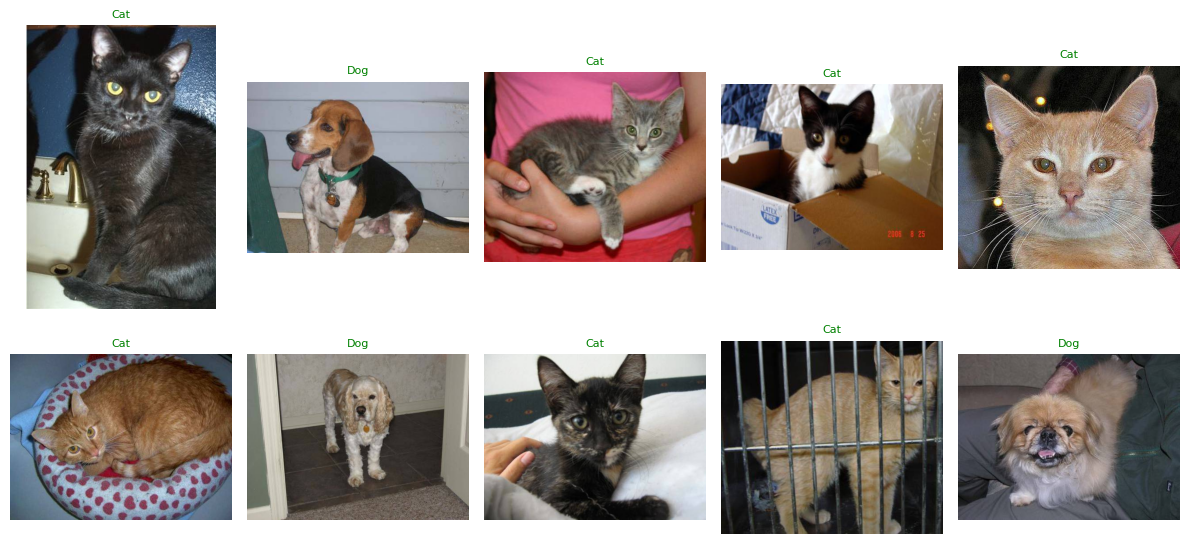

In [ ]:
# 6-5 테스트 데이터셋 이미지 출력
display_image_grid(test_images_filepaths)

In [ ]:
# 6-6 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'): # 데이터셋의 전처리(데이터 변형 적용)
        self.file_list = file_list
        self.transform = transform # DogvsCatDataset클래스 호출시 transform에 대한 매개변수 받아옴
        self.phase = phase # train 적용

    def __len__(self): # images_filpaths 데이터셋의 전체 길이를 반환
        return len(self.file_list)

    def __getitem__(self, idx): # 데이터셋에서 데이터를 가져오는 부분. 결과: 텐서 형태
        img_path = self.file_list[idx]
        img = Image.open(img_path)        # img_path 위치에서 이미지 데이터 가져옴
        img_transformed = self.transform(img, self.phase) # 이미지에 'train' 전처리 적용

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [ ]:
# 6-7 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
# 6-8 이미지 데이터셋 정의
# 훈련 이미지에 train_transforms 적용
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
# 검증 이미지에 test_transforms 적용
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0

print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터의 크기 출력
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 레이블 출력

torch.Size([3, 224, 224])
0


In [ ]:
# 6-9 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader} # 훈련 데이터셋과 검증 데이터셋 합쳐서 표현

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1])


In [ ]:
# 6-10 모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 2D 합성곱층 적용 : 입력(3, 224, 224)->출력(16, 220, 220)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # 최대 풀링 적용 -> (16, 110, 110)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 다시 2D 합성곱층 적용 -> (32, 106, 106)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # 최대 풀링 적용 -> (32, 53, 53)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) # 완전연결층에 데이터 전달하기 위해 데이터형태를 1차원으로 바꿈
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [ ]:

# 6-11 모델 객체 생성
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [ ]:
!pip install torchsummary

In [ ]:
# 6-12 torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [ ]:
# 6-13 학습 가능한 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [ ]:
# 6-14 옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 6-15 모델의 파라미터와 손실 함수를 CPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 6-16 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch): # epoch를 10으로 설정 -> 10회 반복
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 모델을 학습시키겠다
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]): # dataloader_dict: 훈련 데이터셋
                inputs = inputs.to(device) # 훈련 데이터셋을 CPU에 할당
                labels = labels.to(device)
                optimizer.zero_grad() # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # 손실 함수를 이용한 오차 계산

                    if phase == 'train':
                        loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
                        optimizer.step() # optimizer의 step 함수를 호출하면 파라미터를 갱신

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data) # 정답과 예측이 일치하면 그것의 합계를 epoch_corrects에 저장

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset) # 최종 오차 계산(오차를 데이터셋의 길이로 나누어서 계산)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset) # 최종 정확도(epoch_corrects를 데이터셋의 길이로 나누어서 계산)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc: # 검증 데이터셋에 대한 가장 최적의 정확도 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [ ]:
# 6-17 모델 학습
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


/tmp/ipython-input-1938708219.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]): # dataloader_dict: 훈련 데이터셋


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6986 Acc: 0.4700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5217
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7188 Acc: 0.4348
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7042 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7066 Acc: 0.5435
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6842 Acc: 0.5500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6997 Acc: 0.4565
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6772 Acc: 0.5875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5543
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6670 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5326
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6622 Acc: 0.5975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5000
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6707 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7061 Acc: 0.5000
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6475 Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6988 Acc: 0.5543
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6547 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6913 Acc: 0.5326
Training complete in 5m 20s
Best val Acc: 0.554348


In [ ]:
# 6-18 모델 테스트를 위한 함수 정의
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad(): # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타냄/ 훈련 데이터셋의 모델 학습과 가장 큰 차이점
    for test_path in tqdm(test_images_filepaths): # 테스트 데이터셋 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') # 테스트 데이터셋 전처리 적용
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
}) # 테스트 데이터셋의 예측 결과인 id와 레이블을 데이터 프레임에 저장

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('../chap06/data/LesNet.csv', index=False) # 데이터 프레임을 csv파일로 저장

/tmp/ipython-input-1985243384.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # 테스트 데이터셋 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# 6-19 테스트 데이터셋의 예측 결과 호출
res.head(10)

,id,label
0,109,0.346258
1,145,0.339566
2,15,0.528485
3,162,0.430635
4,167,0.517512
5,200,0.321352
6,210,0.548638
7,211,0.529649
8,213,0.345972
9,224,0.554959


In [ ]:
# 6-20 테스트 데이터셋 이미지를 출력하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스 정의
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)    # 데이터 프레임의 id라는 칼럼에서 임의로 데이터를 가져옵니다
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5: # 레이블 값이 0.5보다 크다면 개
            label = 1
        else:         # 레이블 갑시 0.5보다 작다면 고양이
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# AlexNet

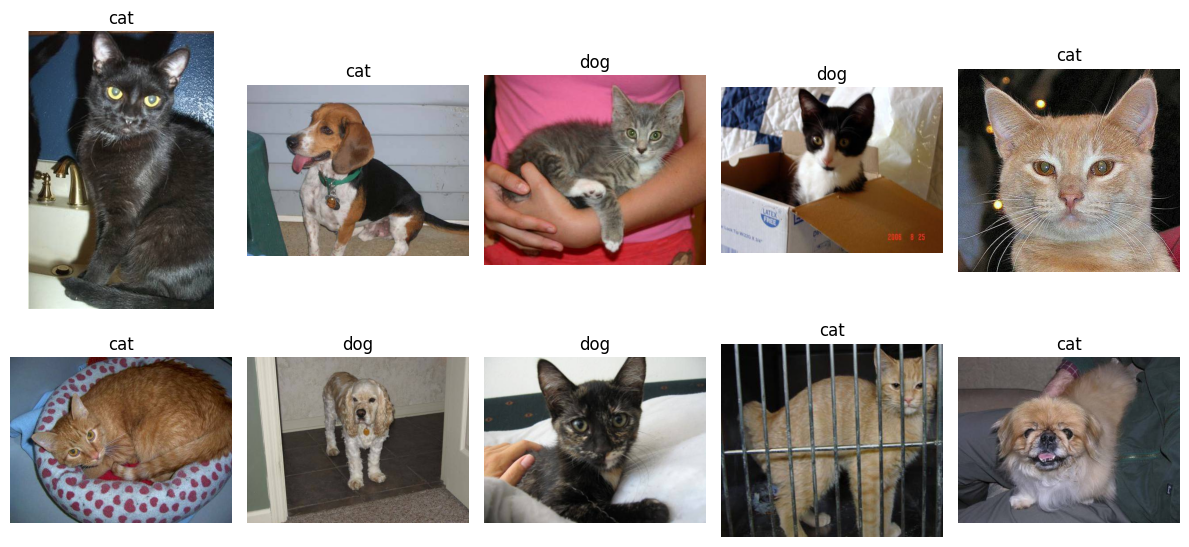

In [ ]:
# 6-21 테스트 데이터셋 예측 결과 이미지 출력
display_image_grid(test_images_filepaths)

In [ ]:
# 6-22 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 6-23 데이터 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
# 6-24 데이터를 가져와서 훈련, 검증, 테스트 용도로 분리
cat_directory = r'../chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'../chap06/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [ ]:
# 6-25 커스텀 데이터셋 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 이미지 데이터가 위치한 파일 경로
        self.transform = transform  # 이미지 데이터 전처리
        self.phase = phase  # self.phase는 ImageTransform()에서 정의한 train과 val 의미함

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]  # 이미지 데이터의 인덱스 가져오기
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0] # 레이블 값을 가져오기
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label # 전처리가 적용된 이미지와 레이블 반환

In [ ]:
# 6-26 변수에 대한 값 정의
size = 256 # AlexNet은 깊이가 깊은 네트워크를 사용하므로, 이미지 크기가 256이 아니면 풀링층 때문에 크기가 계속 줄어 오류 발생할 수 있음
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
# 6-27 훈련, 검증, 테스트 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [ ]:
# 6-28 데이터셋을 메모리롤 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1])


In [ ]:
# 6-29 AlexNet 모델 네트워크 정의
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# 6-30 model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# 6-31 옵티마이저 및 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 6-32 모델 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# 6-33 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [ ]:
# 6-34 모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


/tmp/ipython-input-2746461716.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5109
Training complete in 9m 13s


In [ ]:
# 6-35 모델을 이용한 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths): # 테스트 이미지 데이터 이용
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1] # 이미지 데이터의 번호 가져오기
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val') # 테스트 데이터에 검증용 전처리 적용
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('../chap06/data/alexnet.csv', index=False) # 이미지의 id와 레이블을 alexnet.csv 파일에 저장

/tmp/ipython-input-3380179504.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # 테스트 이미지 데이터 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# 6-36 데이터 프레임 결과 확인
res.head(10)

,id,label
0,145,0.505660
1,211,0.506325
2,162,0.505723
3,200,0.506078
4,210,0.506361
5,224,0.505977
6,213,0.506525
7,109,0.505980
8,15,0.506446
9,167,0.506333


In [ ]:
# 6-37 예측 결과를 시각적으로 표현하기 위한 함수 정의
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

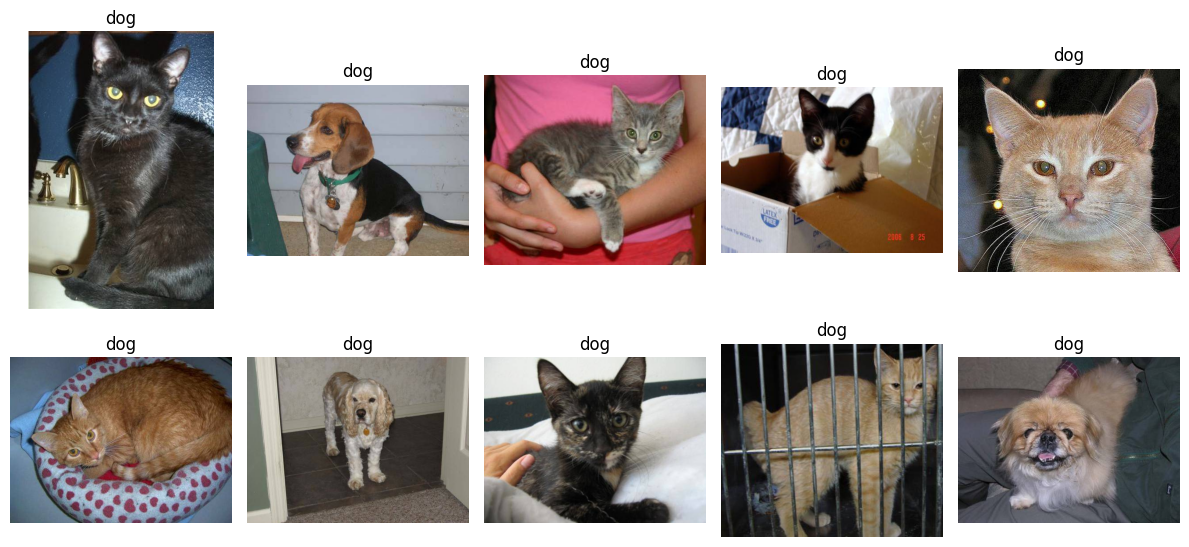

In [ ]:
# 6-38 예측 결과에 대해 이미지와 함께 출력
display_image_grid(test_images_filepaths)